## Discussion on Constrained Optimization Approach on Recommender Systems

When we discuss recommender systems (RSs) we are interested in recommending relevant items to the users in the system. These items can be movies, songs, videos, documents, clothing, and so on. There are various ways to find which items are most relevant to which users. Let's assume every item-user pair has a utility attached to it so that recommending an item $i$ to user $u$ in the system will increase the utility of this user by $\hat{r}_{iu}$. There is extensive research on predicting these values using collaborative, content-based, or hybrid filtering approaches. If we know all the predicted ratings and aim to recommend exactly $k$ many items to the users, the RS problem can be solved with simple sorting. This problem is usually denoted as the top-$k$ recommendation problem. However, solving recommender system problems considering only the user-predicted ratings usually results in unwanted consequences. Before moving on, let us see how this simple sorting algorithm work in the MovieLens-1M dataset.

I use Python 3.10 with conda version 22.9.0 and Gurobi 10.0 throughout.

### MovieLens-1M Dataset
MovieLens-1M is a popular and publicly available dataset of movie ratings submitted by users. Let us investigate this dataset together. You can skip this part if you are accustomed to this dataset.

I use surprise scikit. The documentation can be found here: https://surpriselib.com/ 

```python
conda install -c conda-forge scikit-surprise
conda install pandas
conda install -c conda-forge matplotlib
```

It is a very easy-to-use tool for training recommender systems for small-to-medium-sized datasets. We will also use pandas package to manipulate the data, and matplotlib to visualize it.


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
ML_data = Dataset.load_builtin('ml-1m')
ML_df = pd.DataFrame(ML_data.raw_ratings,columns=['user_id','item_id','rating','timestamp'])


You can download the data to your system this way. Now our data consists of everything we need. Let's see what is going on with this data:

In [56]:
display('Rating_df:', ML_df)
import os
notebook_path = os.path.abspath("Optimization_in_RecSys.ipynb")
user_file = os.path.join(os.path.dirname(notebook_path), ".surprise_data/ml-1m/ml-1m/users.dat")
item_file = os.path.join(os.path.dirname(notebook_path), ".surprise_data/ml-1m/ml-1m/movies.dat")

user_df = pd.read_csv(user_file,delimiter='::',engine='python',header=None,
                      names=['user_id','sex','age','occupation','timestamp'])
item_df = pd.read_csv(item_file,delimiter='::',engine='python',header=None,encoding='ISO-8859-1',
                     names=['item_id','name','genres'])
display('User_df:', user_df)
display('Item_df:', item_df)

'Rating_df:'

,user_id,item_id,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291
...,...,...,...,...
1000204,6040,1091,1.0,956716541
1000205,6040,1094,5.0,956704887
1000206,6040,562,5.0,956704746
1000207,6040,1096,4.0,956715648


'User_df:'

,user_id,sex,age,occupation,timestamp
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


'Item_df:'

,item_id,name,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [57]:
no_user = ML_df.user_id.nunique(); no_item = ML_df.item_id.nunique()
print('Number of users:', no_user)
print('Number of items:', no_item)
print(set(ML_df.rating.values.astype(int)))


Number of users: 6040
Number of items: 3706
{1, 2, 3, 4, 5}


We have three different datasets.  In the ratings dataframe, we observe the ratings submitted by users for items. The ratings take integer values from 1 to 5. The number of users in this dataframe is 6040, and the number of items is 3706. We have approximately 1 million recorded ratings, thus the MovieLens-1M name.

In the user dataframe, we can find information on the sex, age, and occupation of each user. We observe this dataframe has 6040 entries. In the item dataframe, we can see the name and genre information of the items (movies). Note that this dataframe has 3883 while the item ids range from 1 to 3952, this is because some of the item ids are missing. Secondly, the unique item ids observed in the rating dataframe is 3706, while the number of items in the item dataframe is 3883. We can conclude that some of the items have zero observed ratings (none of the users rated them) in this dataset so they do not appear in the ratings dataframe. 


In [104]:
item_df['item_rated'] = item_df['item_id'].map(ML_df.item_id.value_counts())
display(item_df)
display(item_df[item_df['item_id'] == 1196])


,item_id,name,genres,item_rated
0,1,Toy Story (1995),Animation|Children's|Comedy,NaN
1,2,Jumanji (1995),Adventure|Children's|Fantasy,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama,NaN
4,5,Father of the Bride Part II (1995),Comedy,NaN
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,NaN
3879,3949,Requiem for a Dream (2000),Drama,NaN
3880,3950,Tigerland (2000),Drama,NaN
3881,3951,Two Family House (2000),Drama,NaN


,item_id,name,genres,item_rated
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,NaN


In [91]:
from gurobipy import *


2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: item_id, Length: 3706, dtype: int64


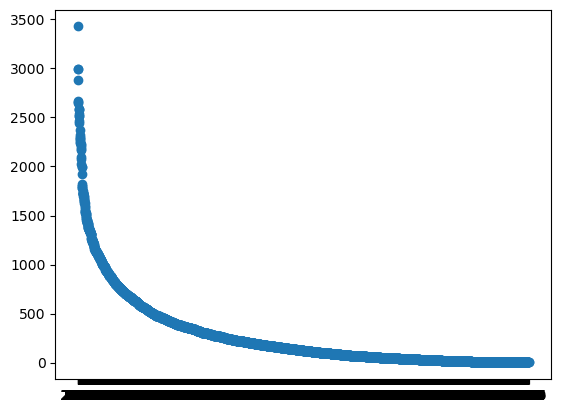

In [114]:

print(ML_df.item_id.value_counts())
plt.scatter(ML_df.item_id.value_counts().index,ML_df.item_id.value_counts())
plt.show()

In [171]:
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import train_test_split

# Train with using SVD method
trainset, testset = train_test_split(ML_data, test_size=0.2)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)


RMSE: 0.8746


0.8746291400217873

We see that regular SVD works good with our dataset with RMSE value of 0.8745. Now, we want to get predictions for all user-item pairs.

In [247]:
 ratings_dict = ML_df.groupby(['user_id', 'item_id']).count().to_dict() # create key if item-user pair exists

# CREATE all the predictions
# This is a slow process because we need to calculate over 22 millions of estimations.
predictions = {}
for uid in set(ML_df.user_id[0]):
    for iid in set(ML_df.item_id):
        if (uid,iid) not in ratings_dict['rating']: # do not recommend already watched movies
            est = algo.predict(uid, iid).est
            predictions[(uid,iid)] = est


Now, we have predictions for all user-item pairs. Let us assume that we want to recommend items that the user did not interact with before. Therefore, we can remove all the items the user rated. Then, if we are solving the top-$k$ problem, the optimal solution is to recommend the highest $k$ predicted utility items to every user. Let $k=10$. This procedure can be done using pandas as follows:

In [248]:
predictions_df = pd.Series(predictions).rename_axis(['user_id', 'item_id']).reset_index(name='pred')


In [253]:
temp = predictions_df.sort_values('pred',ascending=False)
topk = temp.groupby(['user_id']).head(10).reset_index()
display(topk)
print('total_utility',sum(topk['pred'].values))

,index,user_id,item_id,pred
0,2006,1,2324,5.000000
1,1948,1,318,4.912566
2,1118,1,110,4.896597
3,3148,1,916,4.859016
4,2604,1,2905,4.795468
5,841,1,1250,4.795467
6,760,1,3148,4.791246
7,473,1,2396,4.788535
8,2877,1,1131,4.787928
9,3133,1,2357,4.785867


total_utility 48.412689598198995


## Top-$k$ optimal solution

To use Gurobi we need a license. Students can obtain licenses for free for non-commercial purposes, thanks Gurobi! For more information: https://www.gurobi.com/

Now, let us create a simple model to solve the top-$k$ recommendation problem. Decision variables $x_{iu}$ are binary, and they take value 1 if item $i$ is recommended to user $u$, and 0 otherwise. Our objective function is to maximize the total predicted utility. Our only constraint is recommending exactly $k$ many items to every user. Let $k=10$. The model (M1) can be written as follows:


\begin{align}
&\max\limits_{x} \quad \frac{1}{k|U|} \sum \limits_{i \in I}\sum\limits_{u \in U} \hat{r}_{iu}x_{iu}  & & \label{eq:P1_obj_M1} \\
&\text{subject to:} \quad  \sum \limits_{i \in I} x_{iu} = k \quad (\forall u \in U) & &\label{eq:P1_topk_M1}\\
&x_{iu} \in \{0,1\} \quad        (\forall i \in I, u \in U) & &\label{eq:P1_binary_M1}
\end{align}

In [255]:
    mm = Model('Opt')
    u_list = list(set(predictions_df['user_id'].values)); i_list = list(set(predictions_df['item_id'].values))
            
    dvar_tuple = tuple(predictions_df[['user_id','item_id']].itertuples(index=False, name=None))
    x = mm.addVars(dvar_tuple, obj=-predictions_df['pred'].values, vtype=GRB.BINARY)
    mm.addConstrs(quicksum(x[(j,i)] for i in predictions_df[predictions_df['user_id'] == j]['item_id'].values) 
                    == 10 for j in u_list) ###Top-10 recommendation list for every user

    print('opt start')
    mm.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-25
opt start
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 1 rows, 3653 columns and 3653 nonzeros
Model fingerprint: 0x494b5498
Variable types: 0 continuous, 3653 integer (3653 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective -35.6558942
Presolve removed 1 rows and 3653 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 20 available processors)

Solution count 2: -48.4127 -35.6559 
No other solutions better than -48.4127

Optimal solution foun

We see that the simple sorting solution with pandas is the same as the solution obtained from the optimization model M1. When the problem we solve gets more complex, the optimization models will be more advantageous to use compared to simple sorting algorithms.

## Multi-objective Recommender Systems

Initially, recommender systems focused on only the user needs. The main aim was to maximize the user utility or accuracy/recall. However, recommender systems have two other components. Firstly, the providers of the items in the system have their own needs. In our paper "Making smart recommendations for perishable and stockout products," we note that a retailer might recommend soon-to-perish items to users and reduce the number of perished items in the near future. The user utility may suffer but retailer utility will increase. The item providers will not stay in the system if their products are not recommended. Therefore, another aim of the recommender system could be to increase fairness among all the providers. 

## Heuristics vs Optimization

Heuristics are methods or algorithms that help us solve problems with established rules. They "usually" make intuitive sense and are implemented to find a competitive solution to a problem. In contrast, the optimal solution is the "best" solution among all the possible solutions to a problem. In simple terms, optimization software searches among all the possible solutions to find the optimal or almost optimal solutions (within a given tolerance gap). We should note that heuristics are algorithms that may or may not result in the best solution, while optimization algorithms should find the optimal solution. Because we are very ambitious, optimization models are usually slower and require more memory. Optimization models are notorious for being too slow. I will also discuss ways to alleviate the optimization model's speed and memory issues.


In our paper "A Constrained Optimization Approach for Calibrated Recommendations", we investigate a toy example where heuristics can be outperformed by the optimization model. Assume we have a single user with six possible items to recommend. There are three different genres, which are A, B, and C. We want to recommend 3 items (top-$k$=3) with the following objective function:

$\max\limits_{x} \quad \frac{1}{k|U|} \sum\limits_{u \in U} \left[(1- \lambda) \sum \limits_{i \in I} \hat{r}_{iu}x_{iu} -\lambda \sum \limits_{g \in G} \frac{\zeta(p(g|u))}{2}  \Big\lvert p(g|u)- 
    \sum \limits_{i \in I}x_{iu}\frac{p(g|i)}{k}\Big\rvert \right]$

| Item | Estimated rating | Genre group |
|------|------------------|-------------|
| 1    | 4.5              | A           |
| 2    | 4.5              | B           |
| 3    | 4.5              | C           |
| 4    | 4.2              | A,B         |
| 5    | 4.2              | A,C         |
| 6    | 3                | A,B,C       |



The discussion follows in our paper, but the very short outcome is that heuristic applied to this toy examples results in worse scores in both estimated ratings and calibration. The optimization model can find a solution better in all the metrics provided. I continue the discussion of popularity and diversity in the other notebook with a larger dataset: "Spark_ALS_Training." 